# Set-up: Data Download

In [ ]:
!pwd

In [ ]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = "./"
"chmod 600 ./kaggle.json"

In [ ]:
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

In [ ]:
os.listdir(".") #The data have been successfully downloaded. Now we need to unzip.

In [5]:
%%capture
!unzip "./the-simpsons-characters-dataset.zip"

In [ ]:
#checking that all files are the correct file type

# from PIL import Image
# folder_path = 'simpsons_dataset/'
# extensions = []
# for fldr in os.listdir(folder_path):
#     sub_folder_path = os.path.join(folder_path, fldr)
#     for filee in os.listdir(sub_folder_path):
#         file_path = os.path.join(sub_folder_path, filee)
#         print('** Path: {}  **'.format(file_path), end="\r", flush=True)
#         im = Image.open(file_path)
#         rgb_im = im.convert('RGB')
#         if filee.split('.')[1] not in extensions:
#             extensions.append(filee.split('.')[1])

# Introduction

The task: Identify the character from The Simpsons in a particular image

The data: images from kaggle that are of varying sizes and organized by each character

I will focus my techniques to accomplish this task on CNNs and transfer learning.

In [1]:
import tensorflow as tf
from  tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from kerastuner import HyperModel, RandomSearch
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
import os
import numpy as np
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2023-08-18 13:51:27.571436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 13:51:32.377601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_5374/3877253790.py:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


# EDA

In the EDA section of my project I do several things:

1. Preview what each character looks like

2. View class distributions

3. View image size distribution

4. View image color distribution

42 classes:
['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


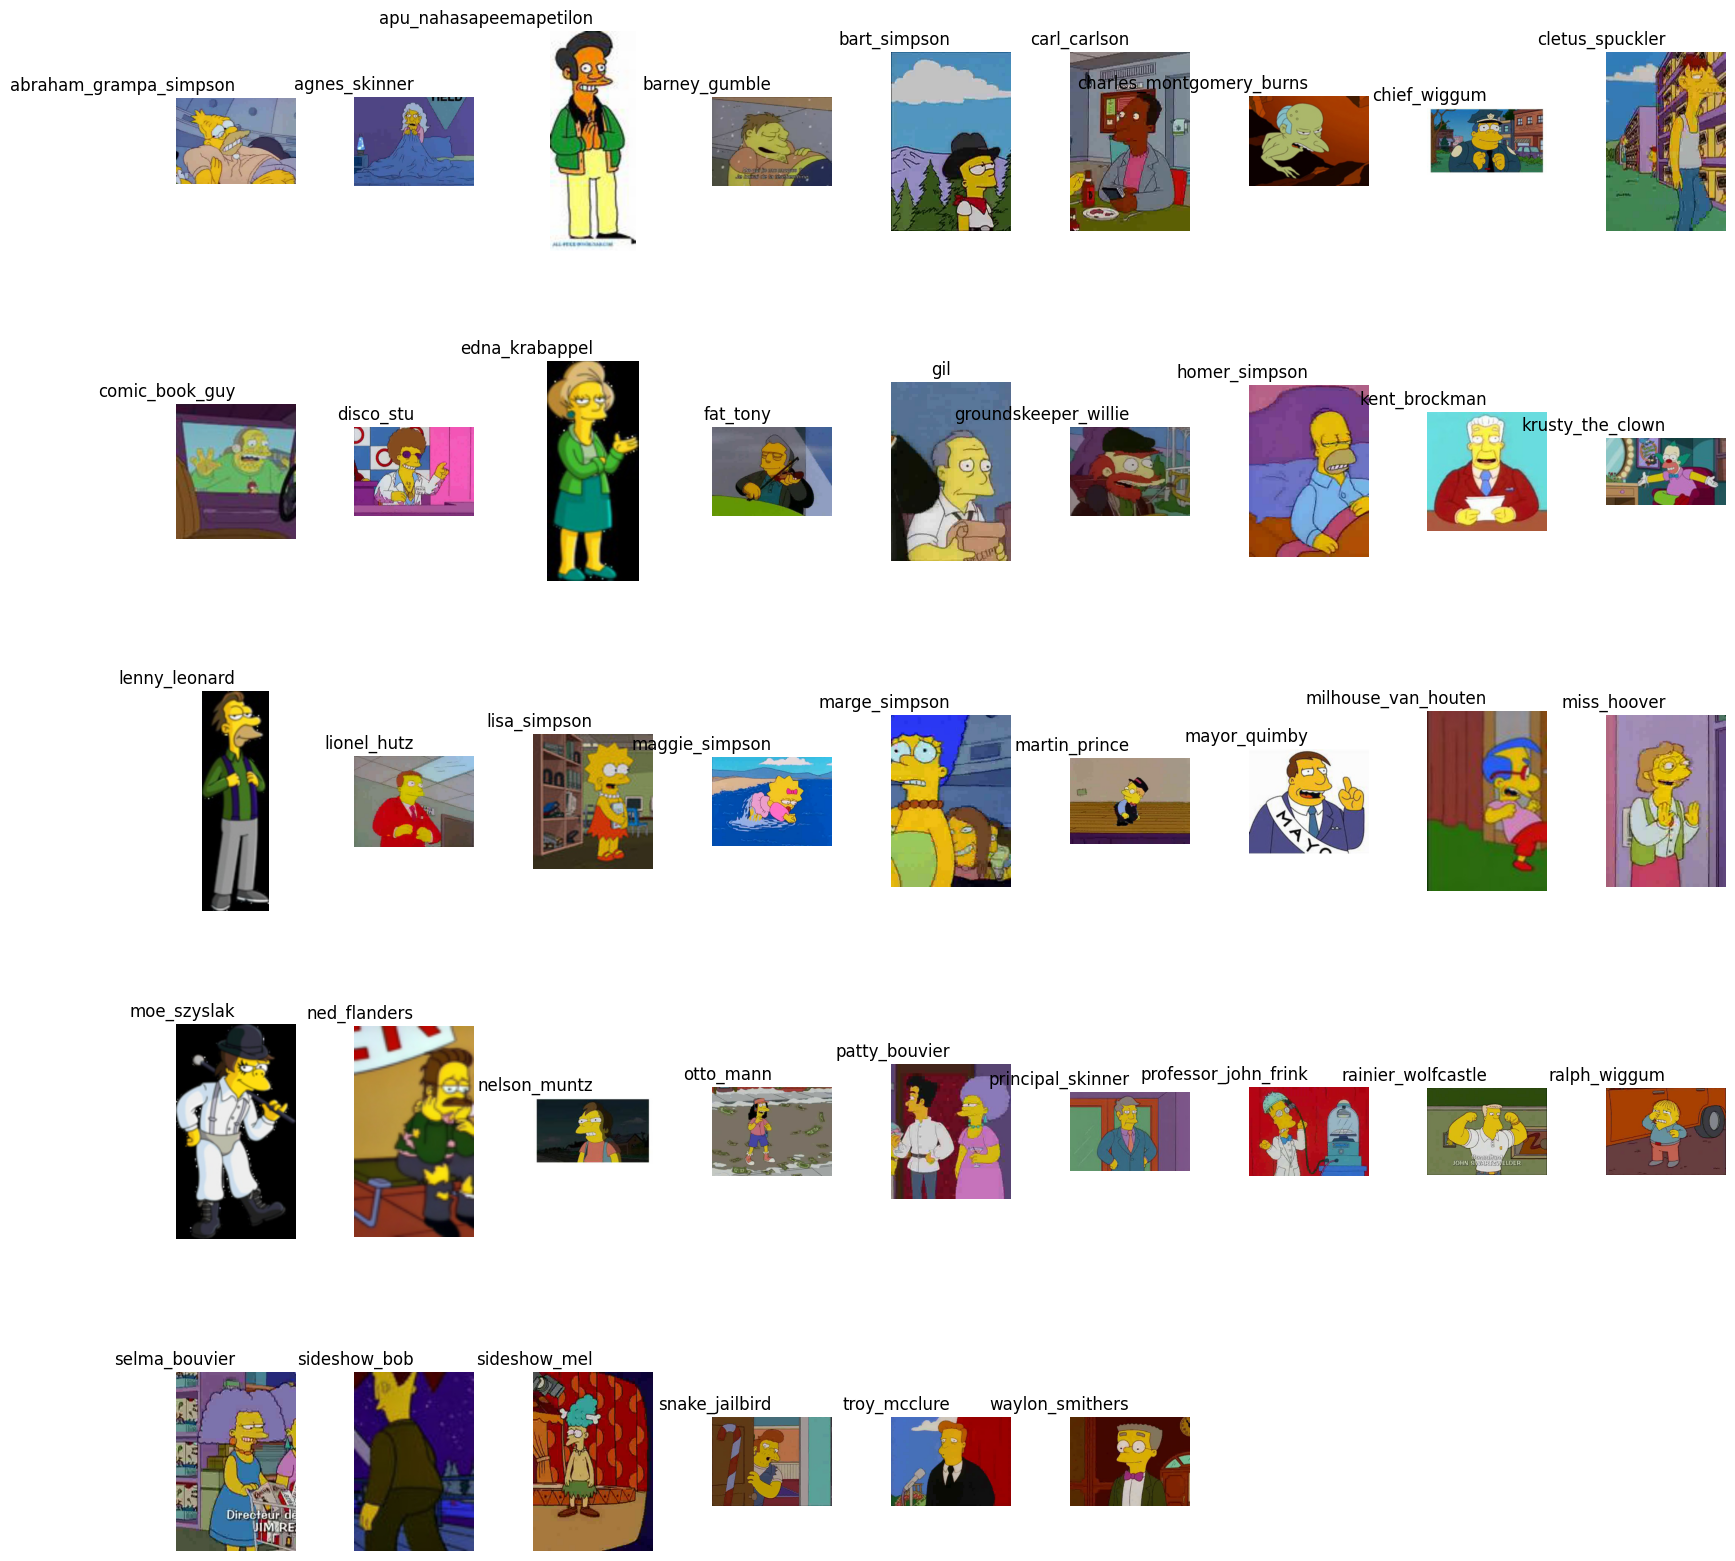

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import os
%matplotlib inline

# The images are in the data/shapes folder
data_folder = 'simpsons_dataset'

# Get the class names
classes = os.listdir(data_folder)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
num_classes = len(classes)
rows = 5  # Number of rows for the subplot grid
cols = (num_classes + rows - 1) // rows  # Calculate the number of columns based on the number of classes

fig = plt.figure(figsize=(20, 20))
for i, sub_dir in enumerate(classes):  # Iterate through class names, not directory contents
    class_folder = os.path.join(data_folder, sub_dir)
    image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpeg') or f.endswith('.jpg')]
    
    if not image_files:
        print(f"No image files found in the folder {class_folder}. Skipping.")
        continue

    img_file = image_files[0]  # Take the first image
    img_path = os.path.join(class_folder, img_file)
    img = mpimg.imread(img_path)
    
    # Check if the image file is valid
    if img is None:
        print(f"Invalid image file: {img_path}. Skipping.")
        continue
    
    a = fig.add_subplot(rows, cols, i + 1)
    a.axis('off')
    imgplot = plt.imshow(img)
    # a.set_title(sub_dir, rotation=45, ha='right')  # Use class name as the title and rotate it for readability
    a.set_title(sub_dir, ha='right')  # Use class name as the title and rotate it for readability

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

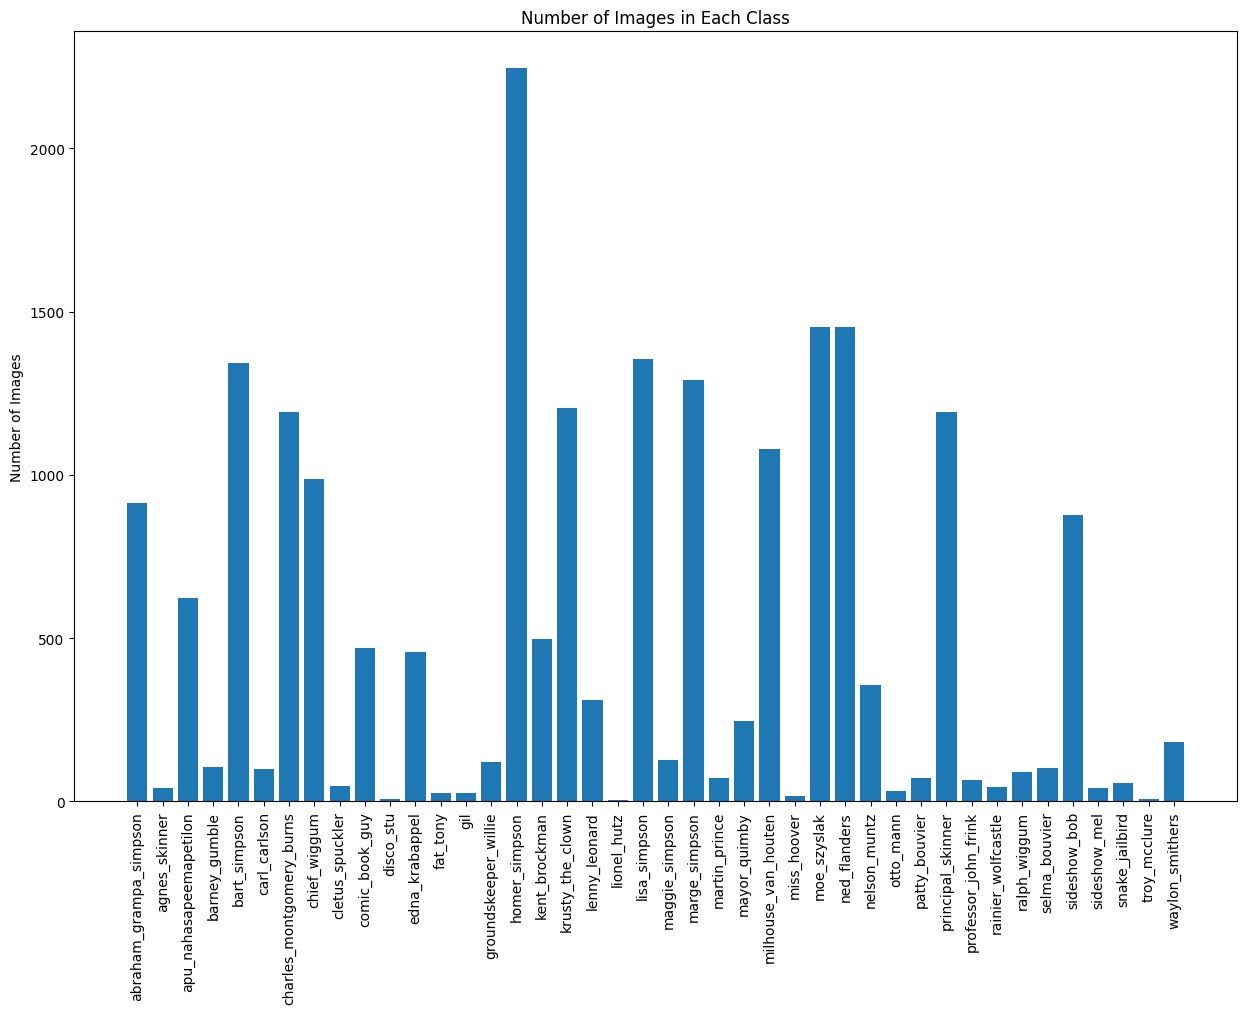

In [3]:
# Count the number of images for each class
image_counts = []
for class_name in classes:
    class_folder = os.path.join(data_folder, class_name)
    image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpeg') or f.endswith('.jpg')]
    image_counts.append(len(image_files))

plt.figure(figsize=(15, 10))
plt.bar(classes, image_counts)
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

In [4]:
data_folder = 'simpsons_dataset'
classes = os.listdir(data_folder)
classes.sort()

# List to store image paths
image_paths = []
labels = []

# Loop through each class folder and gather image paths
for class_idx, class_name in enumerate(classes):
    class_folder = os.path.join(data_folder, class_name)
    image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpeg') or f.endswith('.jpg')]
    
    for img_file in image_files:
        img_path = os.path.join(class_folder, img_file)
        image_paths.append(img_path)
        labels.append(class_idx)

# Convert lists to NumPy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

In [5]:
# Lists to store height, width, and total pixels of each image
heights = []
widths = []
total_pixels = []

# Lists to store mean RGB values for each image
mean_reds = []
mean_greens = []
mean_blues = []

for image_path in image_paths:
    with Image.open(image_path) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)
        total_pixels.append(width * height)

        img_arr = np.array(img)
        mean_reds.append(img_arr[:,:,0].mean())
        mean_greens.append(img_arr[:,:,1].mean())
        mean_blues.append(img_arr[:,:,2].mean())

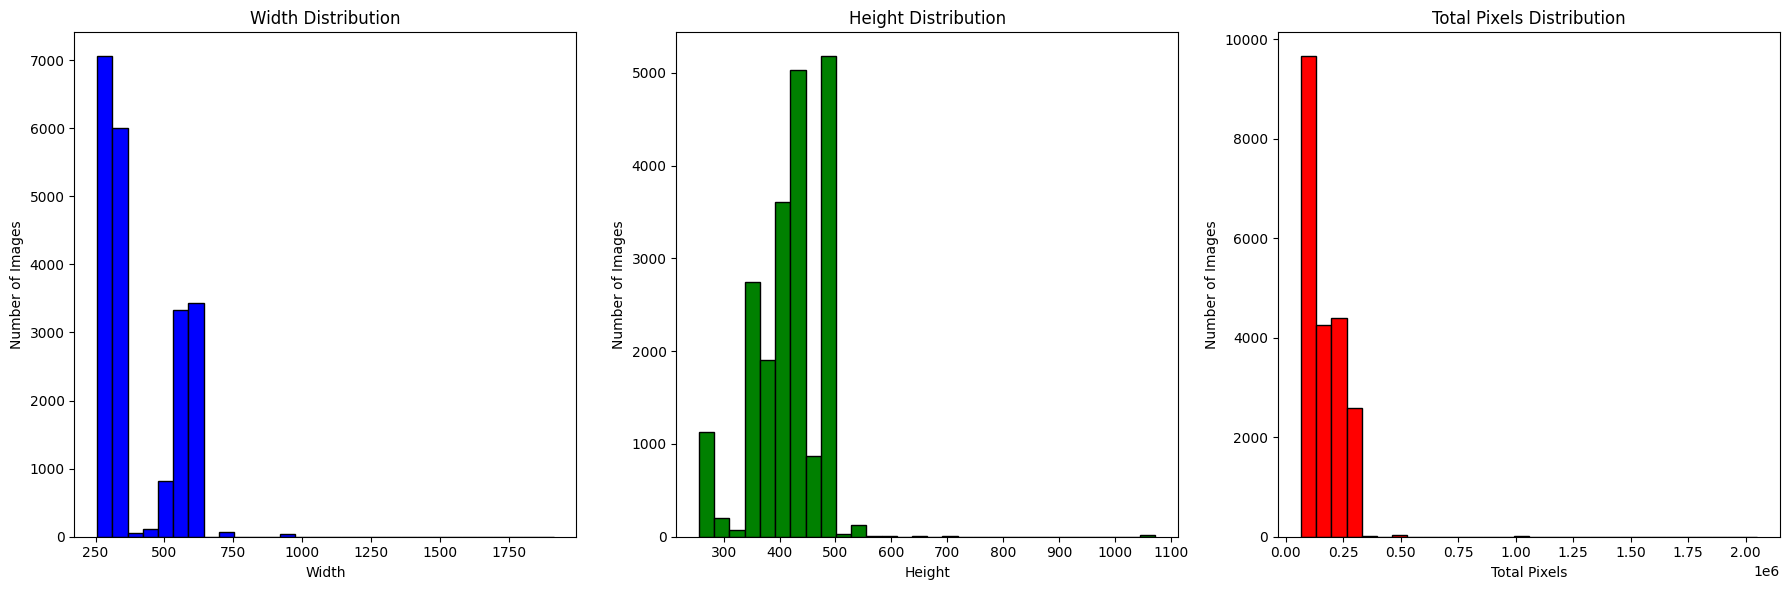

In [6]:
# Plotting width distribution
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(widths, bins=30, color='blue', edgecolor='black')
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Number of Images')

# Plotting height distribution
plt.subplot(1, 3, 2)
plt.hist(heights, bins=30, color='green', edgecolor='black')
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Number of Images')

# Plotting total pixels distribution
plt.subplot(1, 3, 3)
plt.hist(total_pixels, bins=30, color='red', edgecolor='black')
plt.title('Total Pixels Distribution')
plt.xlabel('Total Pixels')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

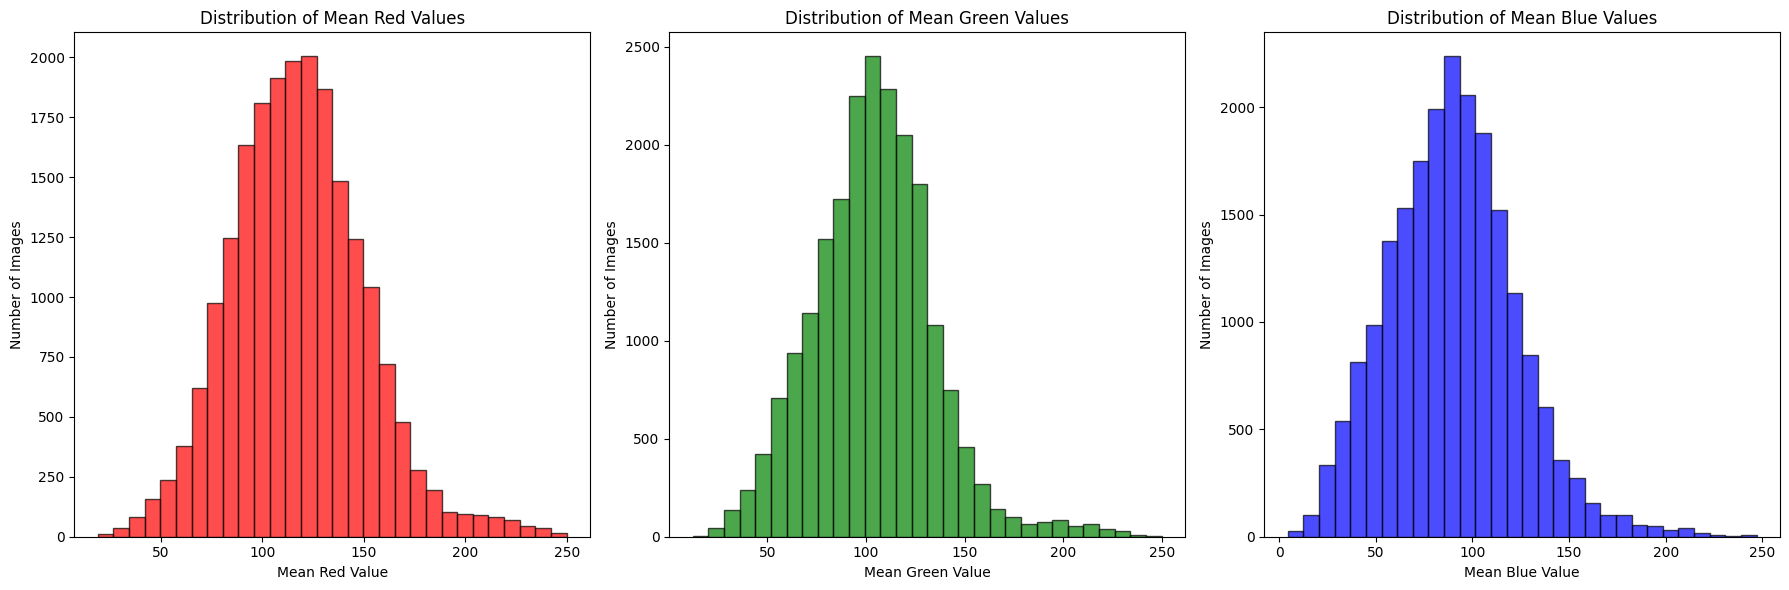

In [7]:
# Plotting distribution of mean red values
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(mean_reds, bins=30, color='red', edgecolor='black', alpha=0.7)
plt.title('Distribution of Mean Red Values')
plt.xlabel('Mean Red Value')
plt.ylabel('Number of Images')

# Plotting distribution of mean green values
plt.subplot(1, 3, 2)
plt.hist(mean_greens, bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Mean Green Values')
plt.xlabel('Mean Green Value')
plt.ylabel('Number of Images')

# Plotting distribution of mean blue values
plt.subplot(1, 3, 3)
plt.hist(mean_blues, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Mean Blue Values')
plt.xlabel('Mean Blue Value')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

# Data Pre-Processing

As seen in the class distrubtion graph above, there are several classes that are under represented. This section is to deal with that and then create the train and test data sets before model training.

In [8]:
class_counts = dict()

for class_idx, class_name in enumerate(classes):
    class_counts[class_name] = np.sum(labels == class_idx)

print(class_counts)

{'abraham_grampa_simpson': 913, 'agnes_skinner': 42, 'apu_nahasapeemapetilon': 623, 'barney_gumble': 106, 'bart_simpson': 1342, 'carl_carlson': 98, 'charles_montgomery_burns': 1193, 'chief_wiggum': 986, 'cletus_spuckler': 47, 'comic_book_guy': 469, 'disco_stu': 8, 'edna_krabappel': 457, 'fat_tony': 27, 'gil': 27, 'groundskeeper_willie': 121, 'homer_simpson': 2246, 'kent_brockman': 498, 'krusty_the_clown': 1206, 'lenny_leonard': 310, 'lionel_hutz': 3, 'lisa_simpson': 1354, 'maggie_simpson': 128, 'marge_simpson': 1291, 'martin_prince': 71, 'mayor_quimby': 246, 'milhouse_van_houten': 1079, 'miss_hoover': 17, 'moe_szyslak': 1452, 'ned_flanders': 1454, 'nelson_muntz': 358, 'otto_mann': 32, 'patty_bouvier': 72, 'principal_skinner': 1194, 'professor_john_frink': 65, 'rainier_wolfcastle': 45, 'ralph_wiggum': 89, 'selma_bouvier': 103, 'sideshow_bob': 877, 'sideshow_mel': 40, 'snake_jailbird': 55, 'troy_mcclure': 8, 'waylon_smithers': 181}


In [9]:
threshold = 450
under_represented_classes = [class_name for class_name, count in class_counts.items() if count < threshold]

print(under_represented_classes)

['agnes_skinner', 'barney_gumble', 'carl_carlson', 'cletus_spuckler', 'disco_stu', 'fat_tony', 'gil', 'groundskeeper_willie', 'lenny_leonard', 'lionel_hutz', 'maggie_simpson', 'martin_prince', 'mayor_quimby', 'miss_hoover', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


In [10]:
# Shuffle the data (optional, but recommended)
shuffle_indices = np.random.permutation(len(image_paths))
image_paths = image_paths[shuffle_indices]
labels = labels[shuffle_indices]

# Split the data into training and validation sets
split_ratio = 0.8  # 80% for training, 20% for validation
split_index = int(len(image_paths) * split_ratio)
train_image_paths = image_paths[:split_index]
train_labels = labels[:split_index]
val_image_paths = image_paths[split_index:]
val_labels = labels[split_index:]

# Function to load and preprocess the images
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # RGB images
    img = tf.image.resize(img, [224, 224])  # Resize to a common size
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img, label

# Create TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.shuffle(buffer_size=len(train_image_paths)).batch(batch_size=32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
val_dataset = val_dataset.map(preprocess_image)
val_dataset = val_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the number of classes and the size of the datasets
print("Number of classes:", len(classes))
print("Training dataset size:", len(train_image_paths))
print("Validation dataset size:", len(val_image_paths))

2023-08-18 14:02:03.546700: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Number of classes: 42
Training dataset size: 16746
Validation dataset size: 4187


In [11]:
def augment_image(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img

def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # RGB images
    img = tf.image.resize(img, [224, 224])  # Resize to a common size
    img = img / 255.0  # Normalize pixel values to [0, 1]
    
    def apply_augmentation():
        return augment_image(img)

    # Check if label is in under_represented_indices
    is_under_represented = tf.reduce_any(tf.equal(label, under_represented_indices))

    # Use tf.cond to conditionally augment images based on the label
    img = tf.cond(is_under_represented,
                  apply_augmentation, 
                  lambda: img)
    
    return img, label

In [12]:
class_to_index = {class_name: index for index, class_name in enumerate(classes)}

under_represented_indices = [class_to_index[class_name] for class_name in under_represented_classes]

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.shuffle(buffer_size=len(train_image_paths)).batch(batch_size=32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
# Folder containing the test images
test_folder = 'kaggle_simpson_testset/kaggle_simpson_testset'

# Get a list of the image files
test_image_files = [f for f in os.listdir(test_folder) if f.endswith('.jpeg') or f.endswith('.jpg')]

# Create a list to store the image paths and labels
test_image_paths = []
test_labels = []

# Extract the class name from the filename and assign a numerical label
for img_file in test_image_files:
    class_name = '_'.join(img_file.split('_')[:-1])
    class_idx = classes.index(class_name)
    img_path = os.path.join(test_folder, img_file)
    test_image_paths.append(img_path)
    test_labels.append(class_idx)

# Convert lists to NumPy arrays
test_image_paths = np.array(test_image_paths)
test_labels = np.array(test_labels)

# Function to load and preprocess the images
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # RGB images
    img = tf.image.resize(img, [224, 224])  # Resize to a common size
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img, label

# Create a TensorFlow dataset for the test data
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))
test_dataset = test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size=32)

print("Test dataset size:", len(test_image_paths))

Test dataset size: 990


# Models and Results

# CNN Modeling

# First Attempt

In [17]:
# Define the CNN model
test_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

# Compile the model
test_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
test_model.summary()

# Train the model
history = test_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Evaluate the model on the validation dataset
loss, accuracy = test_model.evaluate(val_dataset)
print(f"Validation loss: {loss:.4f}, Validation accuracy: {accuracy:.4f}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

2023-08-19 15:31:48.319668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 409 of 16746
2023-08-19 15:31:58.318173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 810 of 16746
2023-08-19 15:32:08.302352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1202 of 16746
2023-08-19 15:32:18.303569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1600 of 16746
2023-08-19 15:32:28.313132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2005 of 16746
2023-08-19 15:32:38.300784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2411 of 16746
2023-08-19 15:32:48.318652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up

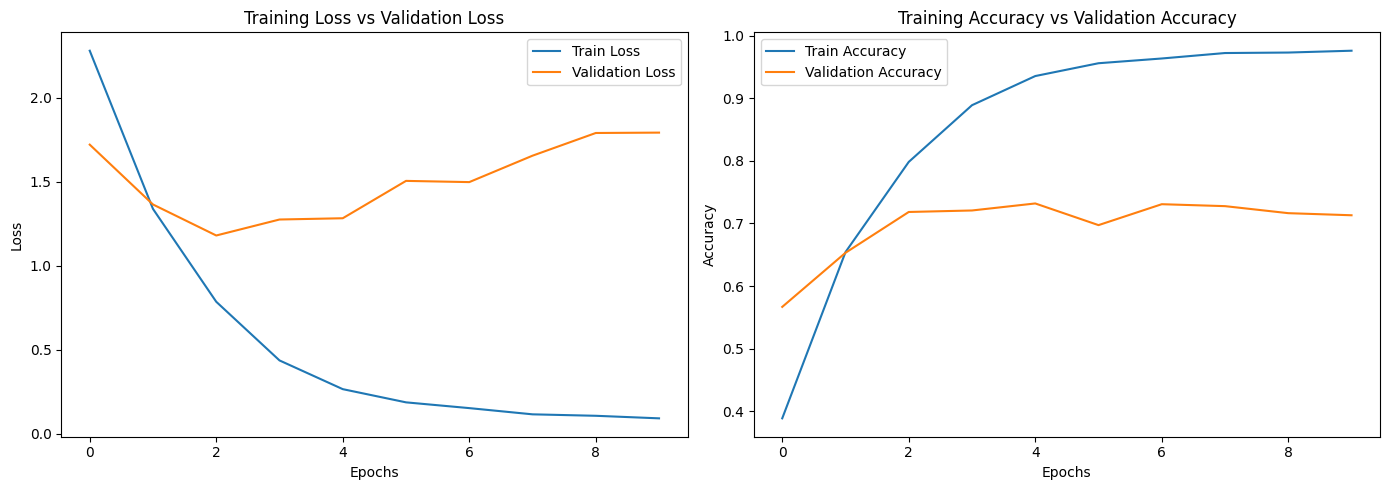

131/131 [==============================] - 32s 242ms/step


In [18]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = np.argmax(test_model.predict(val_dataset), axis=1)
y_true = np.concatenate([y for x, y in val_dataset], axis=0)

unique_class_indices = np.unique(y_pred)

predicted_classes = [classes[i] for i in unique_class_indices]

confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


target_names=classes

missing_class = "disco_stu"
target_names = [name for name in target_names if name != missing_class]

Based on the chart and the output of the model training, I think we have some over-fitting.

# Lets try to improve our CNN

We will try the following:

1. Regularization with dropout layers and l1/l2'

2. Early Stopping and model checkpointing

3. Learning Rate schedule

# 1. Regularization

In [10]:
# 1. Regularization
model_1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

# Compile the model
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model_1.summary()

# Train the model
history_1 = model_1.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Evaluate the model on the validation dataset
loss, accuracy = model_1.evaluate(val_dataset)
print(f"Validation loss: {loss:.4f}, Validation accuracy: {accuracy:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

2023-08-17 13:42:40.712899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 386 of 16746
2023-08-17 13:42:50.702604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 771 of 16746
2023-08-17 13:43:00.709032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1165 of 16746
2023-08-17 13:43:10.716057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1561 of 16746
2023-08-17 13:43:20.718929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1950 of 16746
2023-08-17 13:43:30.709071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2337 of 16746
2023-08-17 13:43:40.716001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up

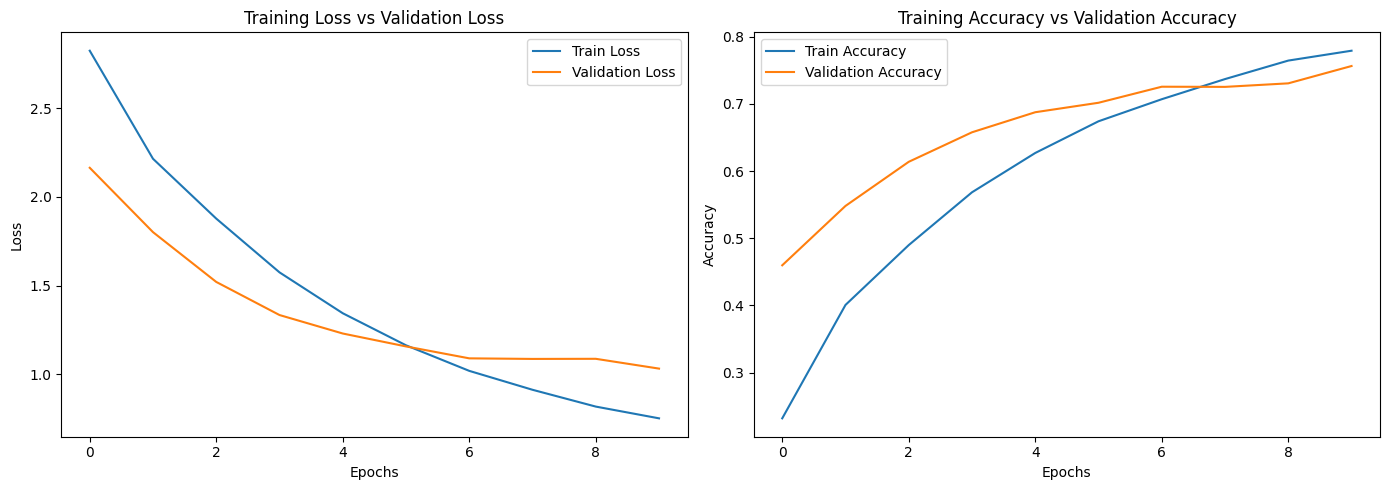

131/131 [==============================] - 34s 256ms/step
['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'mayor_quimby', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'patty_bouvier', 'principal_skinner', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'snake_jailbird', 'waylon_smithers']


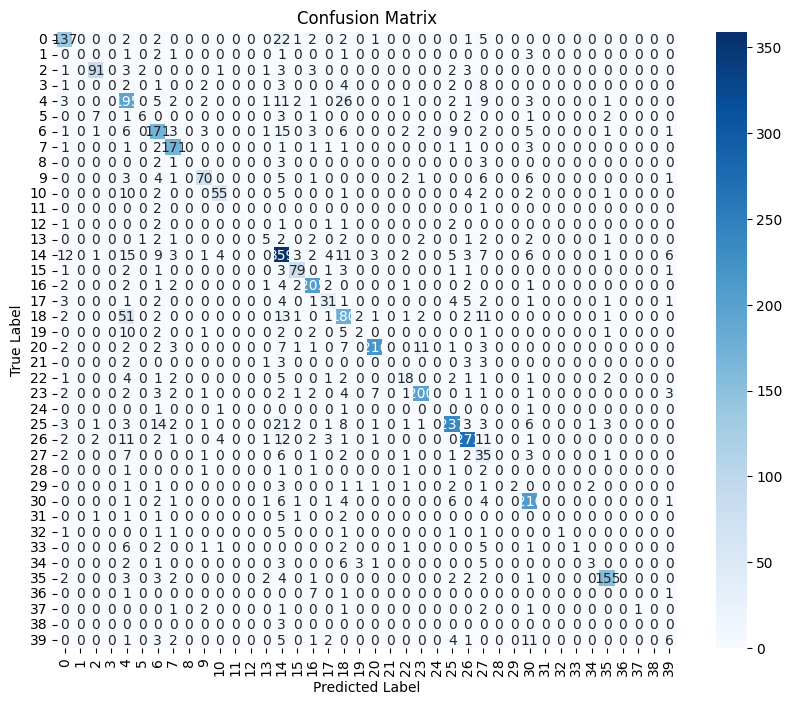

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


In [22]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

y_pred_1 = np.argmax(model_1.predict(val_dataset), axis=1)
y_true_1 = np.concatenate([y for x, y in val_dataset], axis=0)

unique_class_indices = np.unique(y_pred)

predicted_classes = [classes[i] for i in unique_class_indices]
print(predicted_classes)

confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classes)

target_names=classes

missing_classes = ["disco_stu"]
target_names = [name for name in target_names if name not in missing_class]

# 2. Early Stopping and Checkpointing

In [16]:
# 1. Regularization
model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

# Compile the model
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model_2.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history_2 = model_2.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the validation dataset
loss, accuracy = model_2.evaluate(val_dataset)
print(f"Validation loss: {loss:.4f}, Validation accuracy: {accuracy:.4f}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

2023-08-17 16:57:53.740809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 414 of 16746
2023-08-17 16:58:03.737878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 815 of 16746
2023-08-17 16:58:13.744777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1224 of 16746
2023-08-17 16:58:23.726374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1630 of 16746
2023-08-17 16:58:33.724464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2046 of 16746
2023-08-17 16:58:43.726173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2466 of 16746
2023-08-17 16:58:53.733465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up

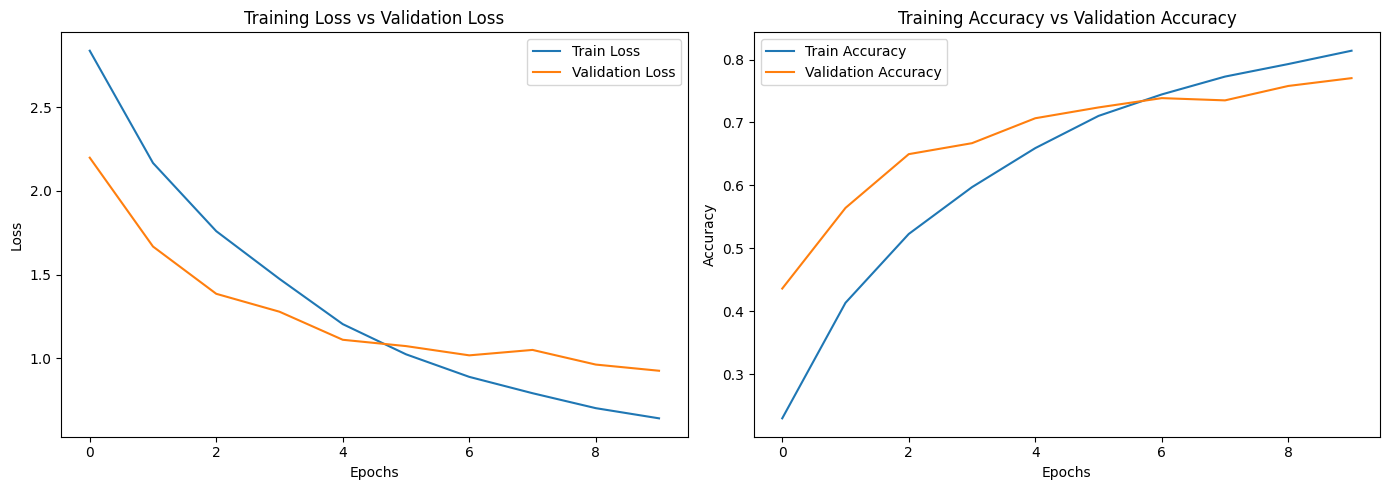

131/131 [==============================] - 33s 251ms/step


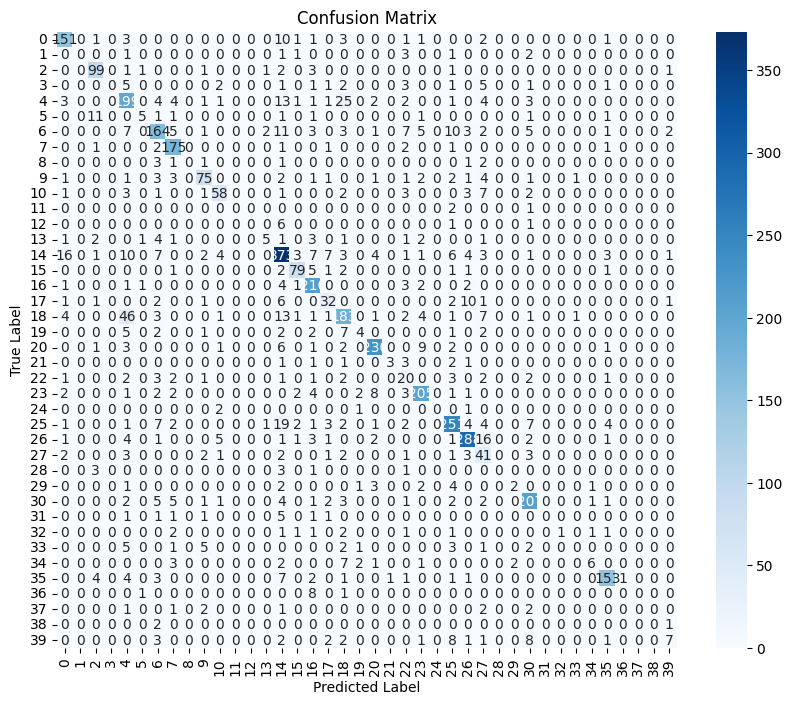

In [23]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = np.argmax(model_2.predict(val_dataset), axis=1)
y_true = np.concatenate([y for x, y in val_dataset], axis=0)

unique_class_indices = np.unique(y_pred)

predicted_classes = [classes[i] for i in unique_class_indices]

confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


target_names=classes

missing_class = "disco_stu"
target_names = [name for name in target_names if name != missing_class]

# 3. Learning Rate Scheduling

In [18]:
# 3. Learning Rate Scheduling
model_3 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

# Compile the model
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model_3.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

# Train the model
history_3 = model_3.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping, model_checkpoint, lr_reduction])

# Evaluate the model on the validation dataset
loss, accuracy = model_3.evaluate(val_dataset)
print(f"Validation loss: {loss:.4f}, Validation accuracy: {accuracy:.4f}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

2023-08-17 19:43:01.504775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 439 of 16746
2023-08-17 19:43:11.508402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 859 of 16746
2023-08-17 19:43:21.512490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1283 of 16746
2023-08-17 19:43:31.529797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1718 of 16746
2023-08-17 19:43:41.514182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2151 of 16746
2023-08-17 19:43:51.516278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2575 of 16746
2023-08-17 19:44:01.519974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up

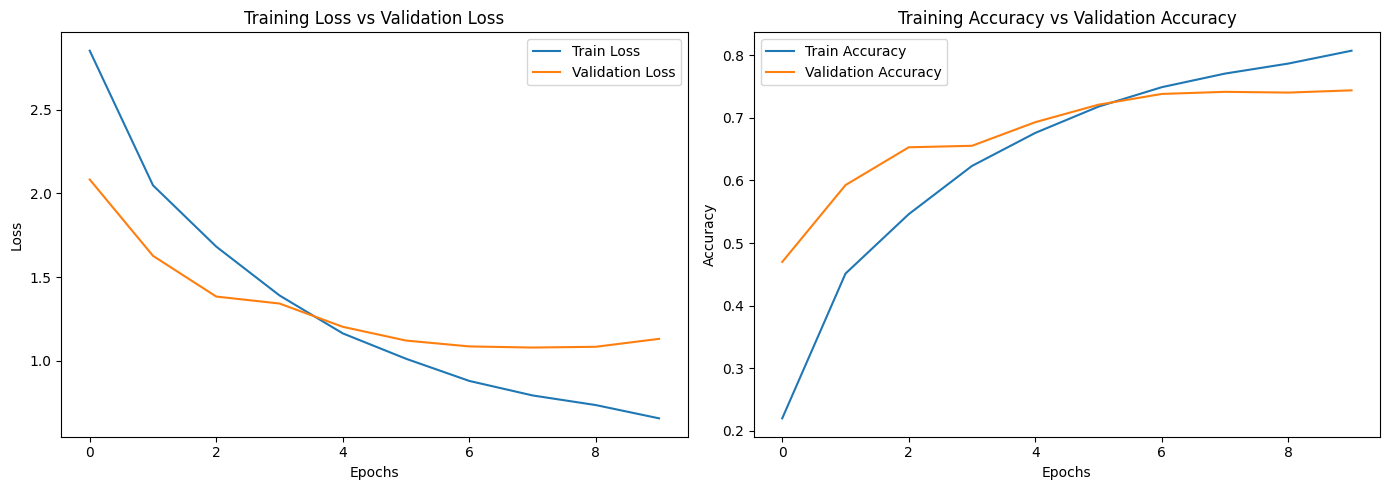

131/131 [==============================] - 33s 251ms/step


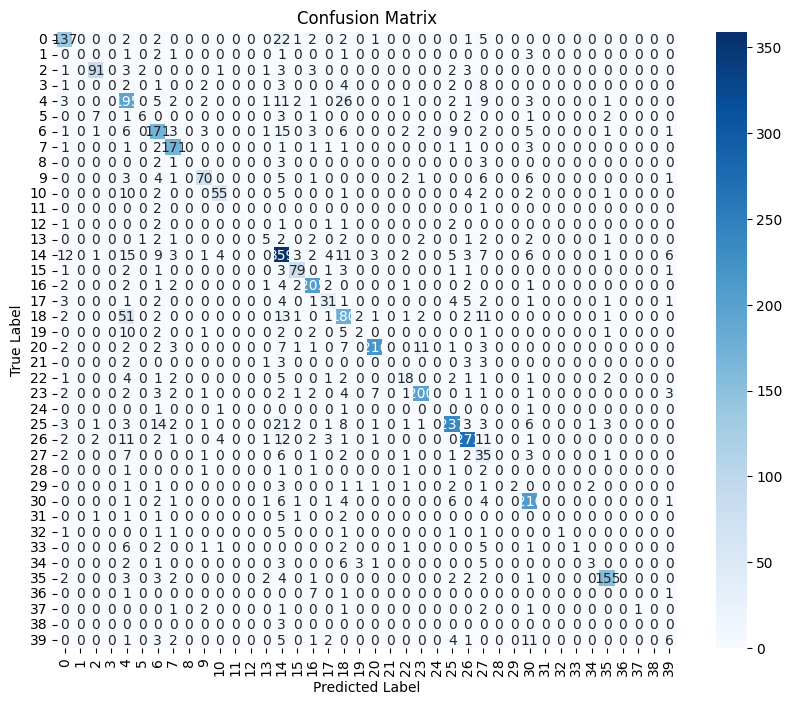

In [21]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = np.argmax(model_3.predict(val_dataset), axis=1)
y_true = np.concatenate([y for x, y in val_dataset], axis=0)

unique_class_indices = np.unique(y_pred)

predicted_classes = [classes[i] for i in unique_class_indices]

confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


target_names=classes

missing_class = "disco_stu"
target_names = [name for name in target_names if name != missing_class]

Change trials and epochs below

# Model Tuning

In [14]:
class CNNHyperModel(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        
    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                                kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                                activation='relu',
                                input_shape=(224, 224, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        
        model.add(layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                                kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                                activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        
        model.add(layers.Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
                                kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
                                activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        
        model.add(layers.Flatten())
        
        model.add(layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                               activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_classes, activation='softmax'))
        
        model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        return model

hypermodel = CNNHyperModel(num_classes=len(classes))

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search',
    project_name='cnn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model_tuned.h5', monitor='val_loss', save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

tuner.search(train_dataset, 
             epochs=6, 
             validation_data=val_dataset, 
             callbacks=[early_stopping, model_checkpoint, lr_reduction])

524/524 [==============================] - 917s 953ms/step - loss: 1.9868 - accuracy: 0.4230 - val_loss: 1.6712 - val_accuracy: 0.5531 - lr: 0.0010
Trial 10 Complete [01h 30m 06s]
val_accuracy: 0.5531406998634338

Best val_accuracy So Far: 0.7157869338989258
Total elapsed time: 21h 25m 20s
INFO:tensorflow:Oracle triggered exit


In [15]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dense_1_units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, 
                    callbacks=[early_stopping, model_checkpoint, lr_reduction])


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 112 and the optimal learning rate for the optimizer
is 0.001.

Epoch 1/10
524/524 [==============================] - 1439s 2s/step - loss: 2.8227 - accuracy: 0.2315 - val_loss: 2.1469 - val_accuracy: 0.4514 - lr: 0.0010
Epoch 2/10
524/524 [==============================] - 1425s 2s/step - loss: 2.0853 - accuracy: 0.4408 - val_loss: 1.6434 - val_accuracy: 0.5711 - lr: 0.0010
Epoch 3/10
524/524 [==============================] - 1424s 2s/step - loss: 1.6633 - accuracy: 0.5551 - val_loss: 1.4207 - val_accuracy: 0.6377 - lr: 0.0010
Epoch 4/10
524/524 [==============================] - 1432s 2s/step - loss: 1.3621 - accuracy: 0.6276 - val_loss: 1.2894 - val_accuracy: 0.6601 - lr: 0.0010
Epoch 5/10
524/524 [==============================] - 1412s 2

2023-08-19 11:31:51.812776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 412 of 16746
2023-08-19 11:32:01.809872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 806 of 16746
2023-08-19 11:32:11.804634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1205 of 16746
2023-08-19 11:32:21.803638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1609 of 16746
2023-08-19 11:32:31.804199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2007 of 16746
2023-08-19 11:32:41.798946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2420 of 16746
2023-08-19 11:32:51.803067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up

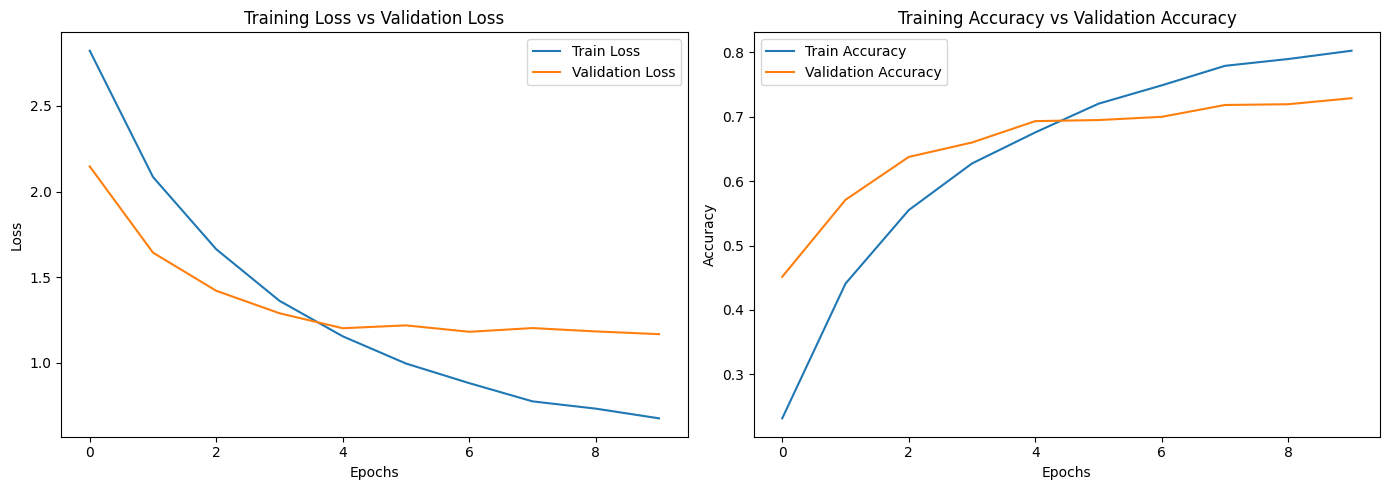

131/131 [==============================] - 55s 419ms/step


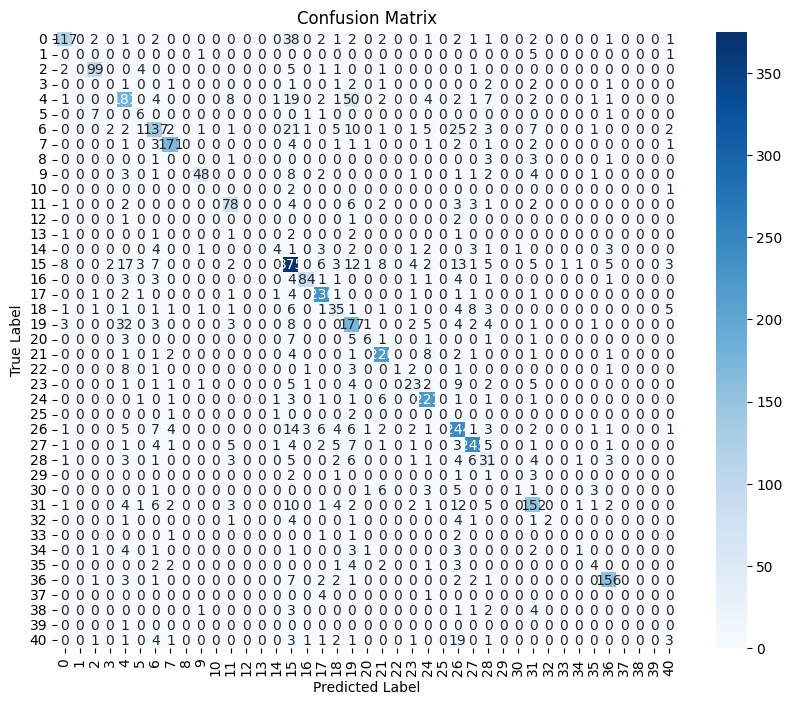

In [16]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(val_dataset), axis=1)
y_true = np.concatenate([y for x, y in val_dataset], axis=0)

unique_class_indices = np.unique(y_pred)

predicted_classes = [classes[i] for i in unique_class_indices]

confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


target_names=classes

missing_class = "disco_stu"
target_names = [name for name in target_names if name != missing_class]

# Transfer Learning

In [25]:
base_model = ResNet50(weights='imagenet', include_top=False)

In [26]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

In [27]:
model = Model(inputs=base_model.input, outputs=predictions)

In [28]:
for layer in base_model.layers:
    layer.trainable = False

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
524/524 [==============================] - 1471s 2s/step - loss: 3.0828 - accuracy: 0.1115 - val_loss: 2.9482 - val_accuracy: 0.1622
Epoch 2/5
524/524 [==============================] - 1433s 2s/step - loss: 2.9517 - accuracy: 0.1469 - val_loss: 2.8809 - val_accuracy: 0.1529
Epoch 3/5
524/524 [==============================] - 1436s 2s/step - loss: 2.8929 - accuracy: 0.1643 - val_loss: 2.8432 - val_accuracy: 0.1834
Epoch 4/5
524/524 [==============================] - 1437s 2s/step - loss: 2.8464 - accuracy: 0.1784 - val_loss: 2.8127 - val_accuracy: 0.1999
Epoch 5/5
524/524 [==============================] - 1435s 2s/step - loss: 2.8067 - accuracy: 0.1933 - val_loss: 2.7488 - val_accuracy: 0.2099


2023-08-18 00:55:32.712945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 390 of 16746
2023-08-18 00:55:42.713997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 777 of 16746
2023-08-18 00:55:52.720899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1169 of 16746
2023-08-18 00:56:02.726501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1561 of 16746
2023-08-18 00:56:12.718350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1960 of 16746
2023-08-18 00:56:22.731531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2348 of 16746
2023-08-18 00:56:32.725356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up

In [31]:
for layer in model.layers[:175]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
524/524 [==============================] - 4264s 7s/step - loss: 4.2762 - accuracy: 0.4017 - val_loss: 5.3622 - val_accuracy: 0.0664
Epoch 2/5
524/524 [==============================] - 4226s 7s/step - loss: 0.9174 - accuracy: 0.7986 - val_loss: 0.9750 - val_accuracy: 0.7879
Epoch 3/5
524/524 [==============================] - 4327s 7s/step - loss: 0.5446 - accuracy: 0.8777 - val_loss: 0.5635 - val_accuracy: 0.8772
Epoch 4/5
524/524 [==============================] - 4358s 8s/step - loss: 0.3462 - accuracy: 0.9225 - val_loss: 0.4517 - val_accuracy: 0.8997
Epoch 5/5
524/524 [==============================] - 4254s 7s/step - loss: 0.2183 - accuracy: 0.9515 - val_loss: 0.3760 - val_accuracy: 0.9145


2023-08-18 02:56:02.899390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 393 of 16746
2023-08-18 02:56:12.879704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 774 of 16746
2023-08-18 02:56:22.898250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1159 of 16746
2023-08-18 02:56:32.884767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1546 of 16746
2023-08-18 02:56:42.886322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1936 of 16746
2023-08-18 02:56:52.903377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2317 of 16746
2023-08-18 02:57:02.892540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up

In [32]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation loss: {loss:.4f}, Validation accuracy: {accuracy:.4f}")

131/131 [==============================] - 201s 2s/step - loss: 0.3760 - accuracy: 0.9145
Validation loss: 0.3760, Validation accuracy: 0.9145


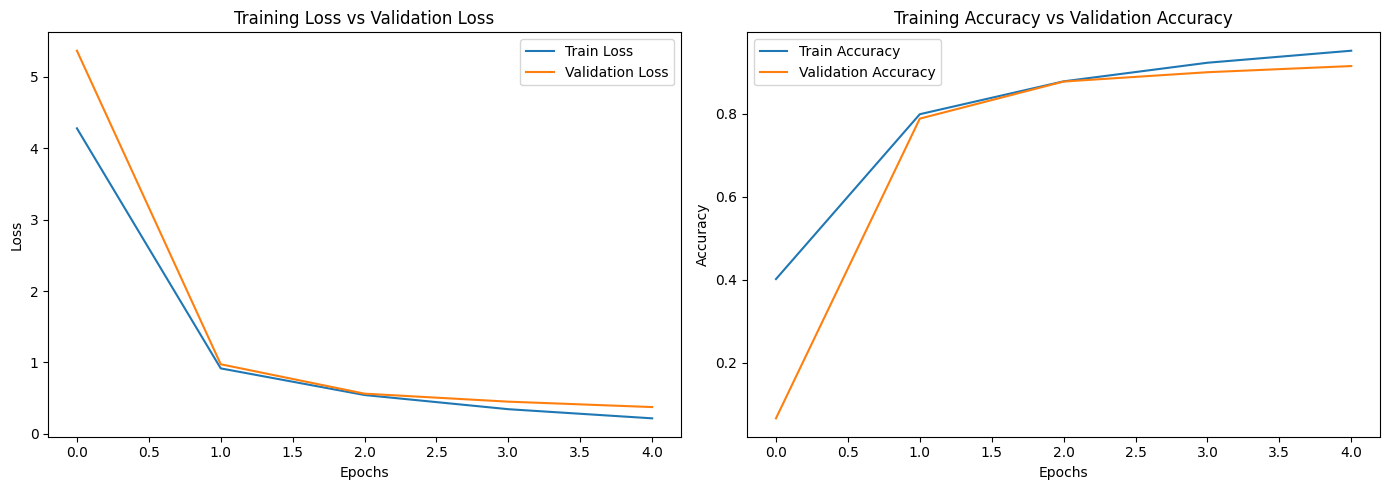

131/131 [==============================] - 204s 2s/step


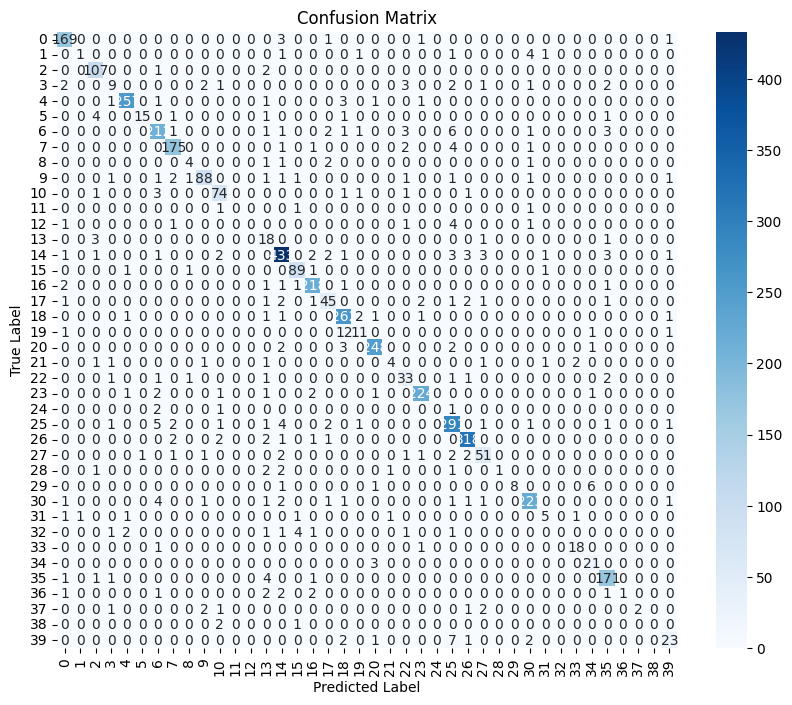

In [33]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(val_dataset), axis=1)
y_true = np.concatenate([y for x, y in val_dataset], axis=0)

unique_class_indices = np.unique(y_pred)

predicted_classes = [classes[i] for i in unique_class_indices]

confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


target_names=classes

missing_class = "disco_stu"
target_names = [name for name in target_names if name != missing_class]

# Conclusion

There are several important key findings from this project. Transfer learning is an incredibly powerful machine learning technique for image classification. Despite making multiple improvements and lengthy hyperparameter tuning, the custom CNN did not perform nearly as well. Also, training time is a very key aspect to consider when work on a time restricted project and finding ways to speed this up is incredibly valuable.

The things I would most like to change in the future are to enable GPU training to speed up training times, improve my hyperparameter tuning methods, and to try more methods of image classification and compare them.

# References

1.	https://en.wikipedia.org/wiki/The_Simpsons

2.	https://www.interpol.int/en/How-we-work/Forensics/Facial-Recognition

3.	https://www.interpol.int/en/How-we-work/Forensics/Facial-Recognition

4.	https://news.asu.edu/20211117-solutions-ethical-implications-facial-recognition-technology

5.	https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset

6.	https://medium.com/analytics-vidhya/image-classification-techniques-83fd87011cac

7.	https://medium.com/analytics-vidhya/image-classification-techniques-83fd87011cac

8.	https://www.simplilearn.com/tutorials/deep-learning-tutorial/guide-to-building-powerful-keras-image-classification-models

9.	https://www.tensorflow.org/tutorials/images/transfer_learning

10.	https://learn.microsoft.com/en-us/training/modules/train-evaluate-deep-learn-models/

